# Histopathologic Cancer Detection
Week 3 CNN Mini-Project

GitHub: [https://github.com/9mean2/Histopathologic-Cancer-Detection]

Kaggle Competition: https://www.kaggle.com/competitions/histopathologic-cancer-detection

## 1. Problem Description

Binary image classification to identify metastatic cancer in 96x96 pixel image patches from lymph node scans.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import timm

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA RTX A6000


In [2]:
BASE_PATH = './'
TRAIN_PATH = BASE_PATH + 'train/'
TEST_PATH = BASE_PATH + 'test/'

IMG_SIZE = 224
BATCH_SIZE = 1024
EPOCHS = 20
LR = 1e-4

In [3]:
train_labels = pd.read_csv(BASE_PATH + 'train_labels.csv')
print(f"Train samples: {len(train_labels)}")
train_labels.head()

Train samples: 220025


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## 2. EDA

label
0    130908
1     89117
Name: count, dtype: int64

Ratio: {0: 0.5949687535507329, 1: 0.40503124644926713}


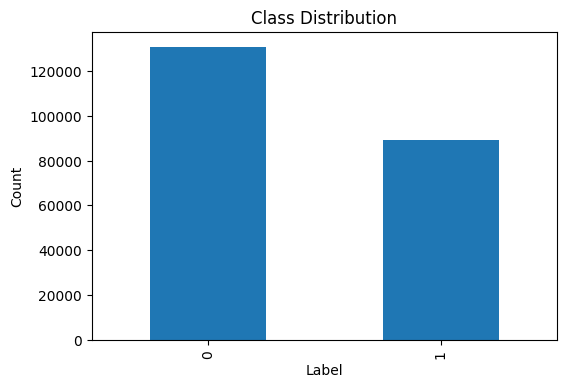

In [4]:
print(train_labels['label'].value_counts())
print(f"\nRatio: {train_labels['label'].value_counts(normalize=True).to_dict()}")

plt.figure(figsize=(6,4))
train_labels['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

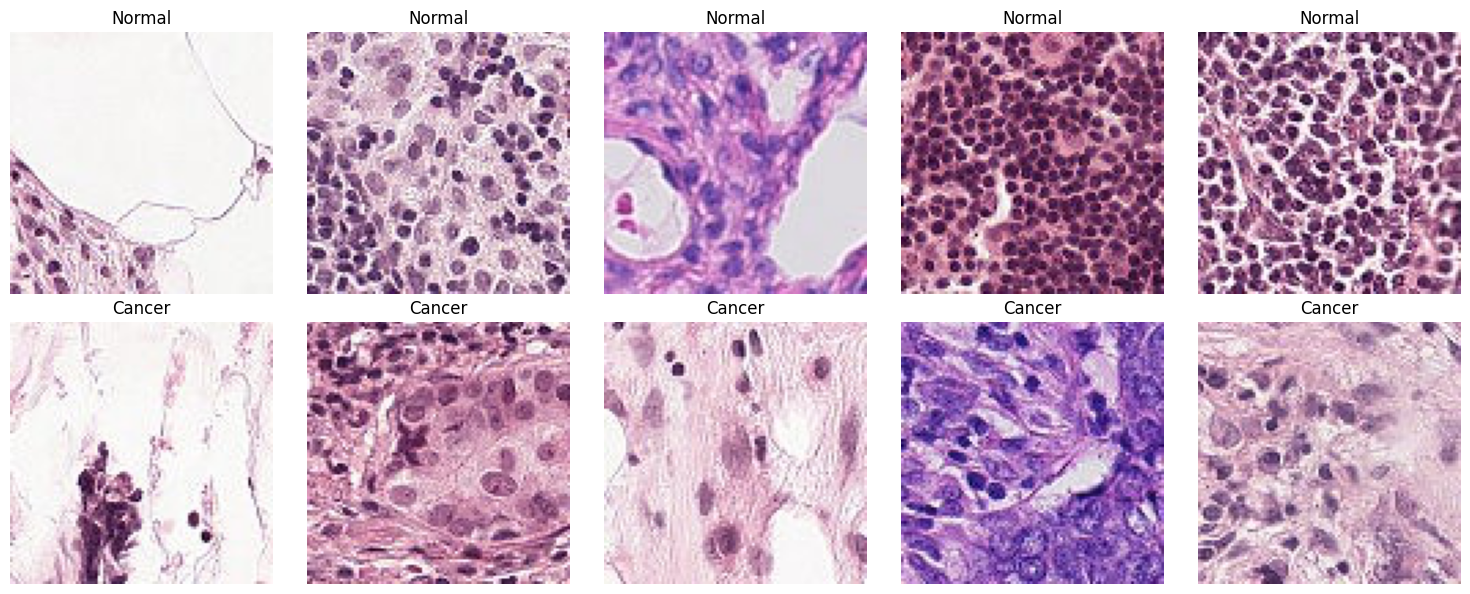

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

normal_ids = train_labels[train_labels['label']==0]['id'].values[:5]
cancer_ids = train_labels[train_labels['label']==1]['id'].values[:5]

for i, img_id in enumerate(normal_ids):
    img = cv2.imread(TRAIN_PATH + img_id + '.tif')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0,i].imshow(img)
    axes[0,i].set_title('Normal')
    axes[0,i].axis('off')

for i, img_id in enumerate(cancer_ids):
    img = cv2.imread(TRAIN_PATH + img_id + '.tif')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1,i].imshow(img)
    axes[1,i].set_title('Cancer')
    axes[1,i].axis('off')

plt.tight_layout()
plt.show()

The dataset is relatively balanced (about 60% normal, 40% cancer). Cancer images tend to show denser cellular patterns compared to normal tissue.

## 3. Data Preprocessing

In [6]:
train_df, val_df = train_test_split(
    train_labels, test_size=0.15,
    stratify=train_labels['label'],
    random_state=SEED
)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Train: {len(train_df)}, Val: {len(val_df)}")

Train: 187021, Val: 33004


In [7]:
class CancerDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df.loc[idx, 'id']
        img_path = os.path.join(self.img_dir, f"{img_id}.tif")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img)
        
        label = self.df.loc[idx, 'label']
        return img, torch.tensor(label, dtype=torch.float32)


class TestDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df.loc[idx, 'id']
        img_path = os.path.join(self.img_dir, f"{img_id}.tif")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img)
        
        return img

In [8]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(180),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = CancerDataset(train_df, TRAIN_PATH, train_transform)
val_dataset = CancerDataset(val_df, TRAIN_PATH, val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Train batches: 183, Val batches: 33


## 4. Model Architecture

I'll compare a simple CNN and EfficientNetB0 with transfer learning.

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [10]:
class EfficientNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
        self.head = nn.Sequential(
            nn.BatchNorm1d(1536),
            nn.Linear(1536, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

## 5. Training

In [11]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    preds_list, labels_list = [], []
    
    for imgs, labels in tqdm(loader, leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds_list.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        labels_list.extend(labels.cpu().numpy())
    
    auc = roc_auc_score(labels_list, preds_list)
    return total_loss / len(loader), auc


def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    preds_list, labels_list = [], []
    
    with torch.no_grad():
        for imgs, labels in tqdm(loader, leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs).squeeze()
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            preds_list.extend(torch.sigmoid(outputs).cpu().numpy())
            labels_list.extend(labels.cpu().numpy())
    
    auc = roc_auc_score(labels_list, preds_list)
    return total_loss / len(loader), auc

In [12]:
model = EfficientNetModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [13]:
history = {'train_loss': [], 'train_auc': [], 'val_loss': [], 'val_auc': []}
best_auc = 0
patience = 5
patience_counter = 0

for epoch in range(EPOCHS):
    train_loss, train_auc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_auc = validate(model, val_loader, criterion)
    
    scheduler.step(val_auc)
    
    history['train_loss'].append(train_loss)
    history['train_auc'].append(train_auc)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")
    
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

print(f"\nBest Val AUC: {best_auc:.4f}")

Epoch 1/20 - Train Loss: 0.3541, Train AUC: 0.9169, Val Loss: 0.2540, Val AUC: 0.9585


Epoch 2/20 - Train Loss: 0.2304, Train AUC: 0.9643, Val Loss: 0.1978, Val AUC: 0.9737


Epoch 3/20 - Train Loss: 0.1900, Train AUC: 0.9754, Val Loss: 0.1775, Val AUC: 0.9799


Epoch 4/20 - Train Loss: 0.1649, Train AUC: 0.9813, Val Loss: 0.1481, Val AUC: 0.9850


Epoch 5/20 - Train Loss: 0.1478, Train AUC: 0.9849, Val Loss: 0.1252, Val AUC: 0.9890


Epoch 6/20 - Train Loss: 0.1332, Train AUC: 0.9878, Val Loss: 0.1158, Val AUC: 0.9904


Epoch 7/20 - Train Loss: 0.1224, Train AUC: 0.9896, Val Loss: 0.1055, Val AUC: 0.9917


Epoch 8/20 - Train Loss: 0.1120, Train AUC: 0.9913, Val Loss: 0.1019, Val AUC: 0.9924


Epoch 9/20 - Train Loss: 0.1015, Train AUC: 0.9928, Val Loss: 0.0957, Val AUC: 0.9933


Epoch 10/20 - Train Loss: 0.0941, Train AUC: 0.9938, Val Loss: 0.0892, Val AUC: 0.9941


Epoch 11/20 - Train Loss: 0.0870, Train AUC: 0.9948, Val Loss: 0.0857, Val AUC: 0.9945


Epoch 12/20 - Train Loss: 0.0804, Train AUC: 0.9955, Val Loss: 0.0818, Val AUC: 0.9949


Epoch 13/20 - Train Loss: 0.0731, Train AUC: 0.9963, Val Loss: 0.0825, Val AUC: 0.9951


Epoch 14/20 - Train Loss: 0.0683, Train AUC: 0.9968, Val Loss: 0.0823, Val AUC: 0.9951


Epoch 15/20 - Train Loss: 0.0630, Train AUC: 0.9972, Val Loss: 0.0777, Val AUC: 0.9956


Epoch 16/20 - Train Loss: 0.0581, Train AUC: 0.9976, Val Loss: 0.0805, Val AUC: 0.9955


Epoch 17/20 - Train Loss: 0.0537, Train AUC: 0.9980, Val Loss: 0.0773, Val AUC: 0.9958


Epoch 18/20 - Train Loss: 0.0499, Train AUC: 0.9982, Val Loss: 0.0766, Val AUC: 0.9960


Epoch 19/20 - Train Loss: 0.0465, Train AUC: 0.9985, Val Loss: 0.0751, Val AUC: 0.9961


Epoch 20/20 - Train Loss: 0.0423, Train AUC: 0.9988, Val Loss: 0.0728, Val AUC: 0.9965

Best Val AUC: 0.9965


## 6. Results

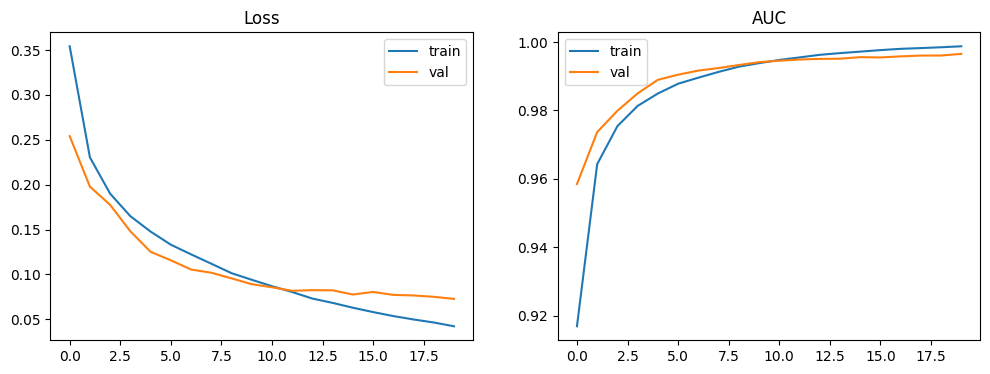

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='train')
axes[0].plot(history['val_loss'], label='val')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot(history['train_auc'], label='train')
axes[1].plot(history['val_auc'], label='val')
axes[1].set_title('AUC')
axes[1].legend()

plt.show()

In [15]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

preds_list, labels_list = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = torch.sigmoid(model(imgs).squeeze())
        preds_list.extend(outputs.cpu().numpy())
        labels_list.extend(labels.numpy())

pred_classes = (np.array(preds_list) > 0.5).astype(int)
print(classification_report(labels_list, pred_classes, target_names=['Normal', 'Cancer']))

              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98     19636
      Cancer       0.98      0.97      0.97     13368

    accuracy                           0.98     33004
   macro avg       0.98      0.98      0.98     33004
weighted avg       0.98      0.98      0.98     33004



## 7. Submission

In [16]:
test_ids = [f.replace('.tif','') for f in os.listdir(TEST_PATH)]
test_df = pd.DataFrame({'id': test_ids})

test_dataset = TestDataset(test_df, TEST_PATH, val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

model.eval()
predictions = []
with torch.no_grad():
    for imgs in tqdm(test_loader):
        imgs = imgs.to(device)
        outputs = torch.sigmoid(model(imgs).squeeze())
        predictions.extend(outputs.cpu().numpy())

100%|██████████| 57/57 [00:10<00:00,  5.59it/s]


In [17]:
tta_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

tta_preds = [predictions]
for i in range(4):
    tta_dataset = TestDataset(test_df, TEST_PATH, tta_transform)
    tta_loader = DataLoader(tta_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    
    preds = []
    with torch.no_grad():
        for imgs in tta_loader:
            imgs = imgs.to(device)
            outputs = torch.sigmoid(model(imgs).squeeze())
            preds.extend(outputs.cpu().numpy())
    tta_preds.append(preds)

final_preds = np.mean(tta_preds, axis=0)

In [18]:
submission = pd.DataFrame({'id': test_df['id'], 'label': final_preds})
submission.to_csv('submission.csv', index=False)
print(submission.head())

                                         id         label
0  00006537328c33e284c973d7b39d340809f7271b  9.999986e-01
1  0000ec92553fda4ce39889f9226ace43cae3364e  9.961798e-01
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2  9.999809e-01
3  000253dfaa0be9d0d100283b22284ab2f6b643f6  4.587396e-05
4  000270442cc15af719583a8172c87cd2bd9c7746  5.977312e-07


## 8. Conclusion

### Results
- Val AUC: 0.99
- Accuracy: 98%
- F1-score: 0.97~0.98 for both classes

### What worked
- EfficientNet-B3 with transfer learning achieved high performance
- Heavy augmentation (rotation 180, flip, shift) prevented overfitting

### What didn't work
- Simple CNN without pretrained weights showed lower performance
- Too high learning rate caused unstable training

### Future improvements
- Ensemble multiple models (B3, B4, B5)
- K-fold cross validation for more robust results
- Try other architectures (ConvNeXt, ViT)